In [1]:
import os
import glob
import logging
import time

import matplotlib.pyplot as plt
import plotly.express as px

import numpy as np
import pandas as pd
from clustergram import Clustergram as CGram

import scipy
from scipy import signal
from scipy import stats

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression as LR

# Peaks detection and features measurment

## Preprocessing

#### Data uploading

In [2]:
total_df = pd.read_csv('output/output_df.csv')
print(total_df.head())
# print(total_df['profile_raw'][total_df['comp'] == 40])

  reg_name     time  comp  profile_raw   profile_C  profile_ddf
0   E_0002  0.00000     2   129.235175 -813.646964          0.0
1   E_0002  1.09006     2   128.213577 -813.646964          0.0
2   E_0002  2.18012     2   127.136172 -813.646964          0.0
3   E_0002  3.27018     2   129.521864 -813.646964          0.0
4   E_0002  4.36024     2   129.232642 -813.646964          0.0


In [3]:
# plt.figure(figsize=(15, 10))
# for i in total_df.comp.unique():
#     time_series = total_df['time'][total_df['comp'] == i]
#     profile_series = total_df['profile_raw'][total_df['comp'] == i]
#     plt.plot(time_series, profile_series, alpha=.5, label=i)
# plt.legend()
# plt.show()

fig=px.line(total_df,
            y='profile_raw',
            x='time',
            color='comp',
            animation_frame="comp")
fig.show()

#### Profiles normalization and global sample option

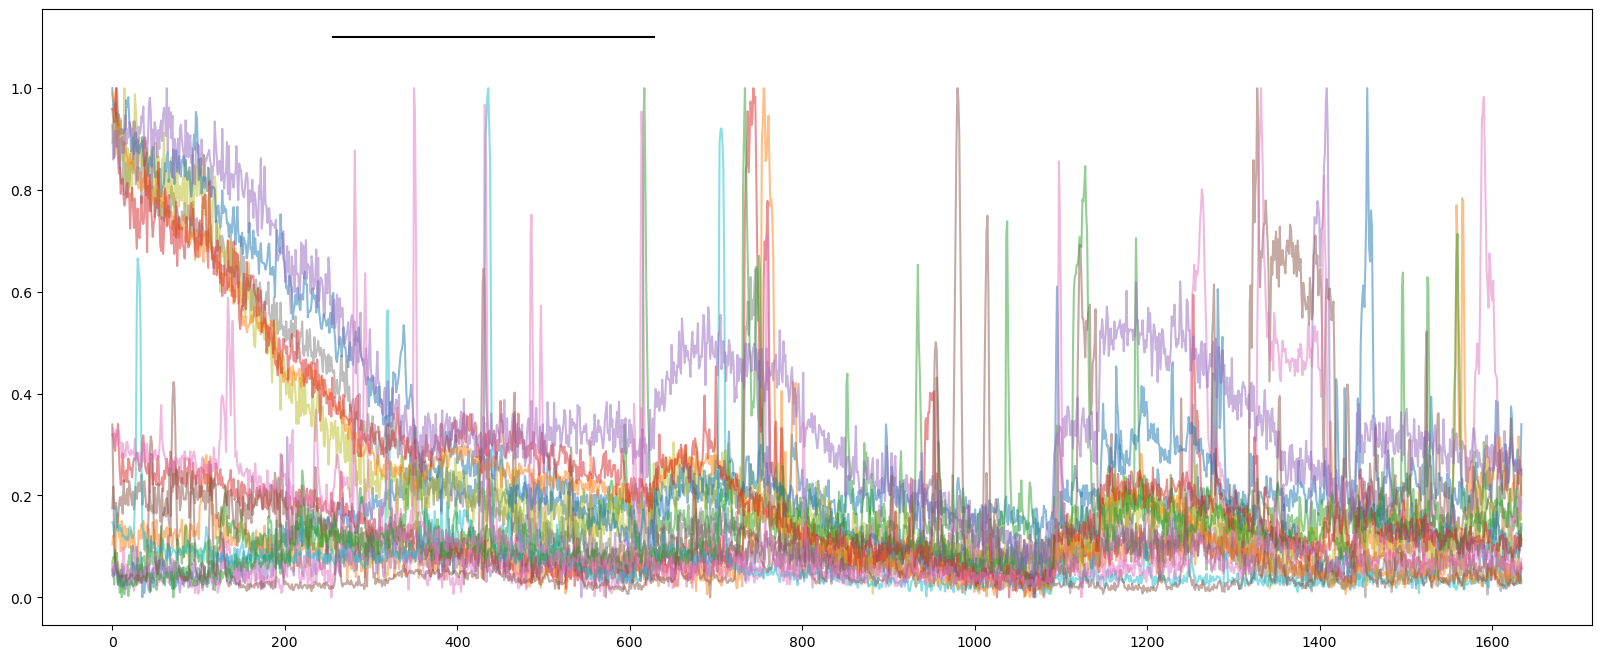

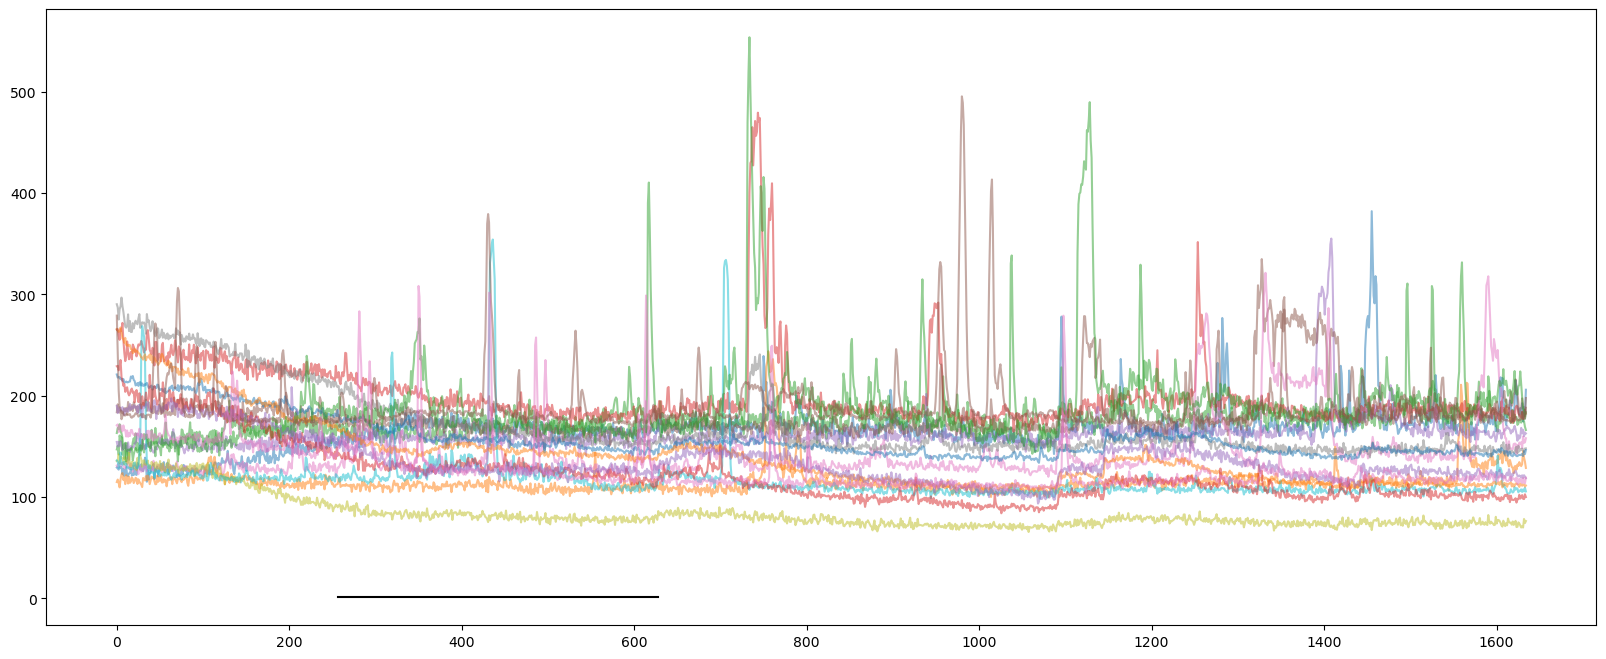

In [4]:
# https://stackoverflow.com/questions/66399486/how-to-find-out-peak-rise-and-decay

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

def norm_profiles_to_arr(input_df):
    """ Normilize Ca profiles in 0-1 range
    Return: np array [component, raw_profile, norm_profile]
    """
    output_arr = []
    comp_list = np.array(total_df.comp.unique())
    for comp in comp_list:
        comp_profile_raw = np.array(input_df['profile_raw'][input_df['comp'] == comp])
        comp_profile_norm = (comp_profile_raw-np.min(comp_profile_raw)) / (np.max(comp_profile_raw) - np.min(comp_profile_raw))
        output_arr.append([comp_profile_raw, comp_profile_norm])
    return np.asarray(output_arr)


norm_profiles = norm_profiles_to_arr(total_df)
# print(norm_profiles.shape)

# global sample options
total_reg_t = 1634
frame_time = total_reg_t / norm_profiles.shape[-1]

app_start_t = 256
app_end_t = 628
reg_name = 'E_0002'

time_line = np.linspace(0, total_reg_t, num=norm_profiles.shape[-1])
app_line = np.linspace(app_start_t, app_end_t)

# plotting
plt.figure(figsize=(20, 8))
for one_prof in norm_profiles:
    plt.plot(time_line, one_prof[1], alpha=.5)
plt.plot(app_line, [1.1] * len(app_line), label='App. time', color='k')
plt.show()

plt.figure(figsize=(20, 8))
for one_prof in norm_profiles:
    plt.plot(time_line, one_prof[0], alpha=.5)
plt.plot(app_line, [1.1] * len(app_line), label='App. time', color='k')
plt.show()

## Peaks detection and features measurment

#### Detection and measurment options

In [5]:
# profile_std = np.std(comp_profile)
# print(profile_std)

# detection options
min_distance_sec = 3
min_distance_frames = int(min_distance_sec / frame_time)
if min_distance_frames < 1:
    min_distance_frames = 1

width_sec = [1, 200]  # [min, max]
width_frames = np.asanyarray([width_sec[0]/frame_time, width_sec[1]/frame_time], dtype=int)  # [min, max]

plat_sec = [1, 100]  # [min, max]
plat_frames = np.asarray([plat_sec[0]/frame_time, plat_sec[1]/frame_time], dtype=int)
plat_frames[plat_frames == 0] = 1

# ΔF/F options
delta_win_shift = 0
delta_win_size = 10


#### All-components peaks detection features data frame creation

In [6]:
# peaks features data frame init
pf_df = pd.DataFrame(columns=['sample',          # sample name
                              'comp',            # spatial component ID
                              'app_group',       # application group, before/after bath application
                              'peak_num',        # peak number in profile
                              'peak_i',          # peal index in profile, frames
                              'peak_time',       # peak time, sec
                              'rise',            # rise time, sec
                              'decay',           # decay time, sec
                              'FWHM',            # full width at half maximum, sec
                              'amp_abs',         # absolute amplitude, a.u.
                              'prom_abs',        # prominence from raw profile, a.u.
                              'integral_abs',    # signal integral in rise-decay window by raw profile
                              'amp_dF',          # relative amplitude, ΔF/F
                              'integral_dF',     # signal integral in rise-decay window by relative profile, ΔF/F
                              'amp_norm',        # normalize amplitude, 0-1 range
                              'prom_norm',       # prominence from normalized profile, 0-1 range
                              'integral_norm'])  # signal integral in rise-decay window by normalized profile            

components_ID = np.array(total_df.comp.unique())
for component_num in [0]:  # range(norm_profiles.shape[0]):
    comp_ID = components_ID[component_num]

    comp_raw_profile = norm_profiles[component_num][0]
    comp_norm_profile = norm_profiles[component_num][1]

    comp_peaks, comp_properties = signal.find_peaks(comp_norm_profile,
                                                    height=None,
                                                    threshold=None,
                                                    distance=min_distance_frames,
                                                    wlen=100,
                                                    prominence=0.15,
                                                    rel_height=0.5,
                                                    width=width_frames,
                                                    plateau_size=plat_frames)
                                                    
    prom_raw = signal.peak_prominences(comp_raw_profile, comp_peaks, wlen=100)[0]

    for peak_i in range(len(comp_peaks)):
        # features calc
        peak_index = comp_peaks[peak_i]
        peak_time = time_line[peak_index]
        if peak_time < app_start_t:
            app_group = 'before'
        else:
            app_group = 'after'

        # high features section
        amp_abs = comp_raw_profile[peak_index]
        amp_norm = comp_norm_profile[peak_index]

        prom_abs = prom_raw[peak_i]
        prom_norm = comp_properties['prominences'][peak_i]

        # time features section
        rise = peak_index - comp_properties['left_bases'][peak_i]
        decay = comp_properties['right_bases'][peak_i] - peak_index

        fwhm = comp_properties['widths'][peak_i]
        
        # signal integral section
        peak_bool_mask = np.zeros_like(comp_norm_profile, dtype=bool)
        peak_bool_mask[comp_properties['left_bases'][peak_i]:comp_properties['right_bases'][peak_i]] = 1
        integral_abs = np.sum(comp_raw_profile, where=peak_bool_mask)
        integral_norm = np.sum(comp_norm_profile, where=peak_bool_mask)

        # ΔF/F section
            # NOT WORKING BECAUSE OF DOUBLE-PEAKS
            # delta_win_r_i = comp_properties['left_bases'][peak_i] - delta_win_shift
            # delta_win_l_i = delta_win_r_i - delta_win_size
            # F0_val = np.mean(comp_raw_profile[delta_win_l_i:delta_win_r_i])
            # amp_dF = (amp_abs-F0_val) / F0_val

        amp_dF = prom_abs / (amp_abs - prom_abs)
        print(amp_dF)

        peak_slice = comp_raw_profile[comp_properties['left_bases'][peak_i]:comp_properties['right_bases'][peak_i]]
        peak_dF = peak_slice / (amp_abs - prom_abs)
        print(peak_slice)
        print(peak_dF)
        integral_dF = np.sum(peak_dF)
        
    
        # data frame update
        pf_row = pd.DataFrame({'sample':[reg_name],               # sample name
                               'comp':[comp_ID],                  # spatial component ID
                               'app_group':[app_group],           # application group, before/after bath application
                               'peak_num':[peak_i],               # peak number in profile
                               'peak_i':[peak_index],             # peak index in profile, frames
                               'peak_time':[peak_time],           # peak time, sec
                               'rise':[rise * frame_time],        # rise time, sec
                               'decay':[decay * frame_time],      # decay time, sec
                               'FWHM':[fwhm * frame_time],        # full width at half maximum, sec  
                               'amp_abs':[amp_abs],               # absolute amplitude, a.u.
                               'prom_abs':[prom_abs],             # prominence from raw profile, a.u.
                               'integral_abs':[integral_abs],     # signal integral in rise-decay window from raw profile
                               'amp_dF':[amp_dF],                 # relative amplitude, ΔF/F
                               'integral_dF':[integral_dF],       # signal integral in rise-decay window by relative profile, ΔF/F
                               'amp_norm':[amp_norm],             # normalize amplitude, 0-1 range
                               'prom_norm':[prom_norm],           # prominence from normalized profile, 0-1 range
                               'integral_norm':[integral_norm]})  # signal integral in rise-decay window from normalized profile      
        pf_df = pd.concat([pf_df, pf_row], ignore_index=True)

print(pf_df.head())

0.4897447012331665
[158.17446139 239.21475043 227.11556101 205.07511199 213.6727949
 191.10793515 185.91216937 190.75614601 183.66699552 183.00909236
 194.22582924 170.37638652 181.67900757 185.97001653 179.84817619
 178.78546288 177.19256613 173.39711764 178.82191233 182.83276451
 170.39157157 172.83215124 171.37206698 170.9546715  173.96179074
 167.2650384  172.56723283 165.62022718 172.18422035 169.72946886
 169.95432487]
[0.9850545  1.4897447  1.41439524 1.27713513 1.33067845 1.1901525
 1.15779511 1.18796168 1.14381297 1.13971578 1.20956964 1.06104376
 1.13143248 1.15815537 1.12003071 1.11341251 1.10349251 1.07985581
 1.11363951 1.13861767 1.06113833 1.0763374  1.06724451 1.06464512
 1.08337239 1.04166739 1.07468758 1.03142409 1.07230231 1.05701499
 1.05841531]
0.321890560037246
[152.56987255 163.92656783 161.01989121 159.95097856 169.93467363
 169.47093643 179.01542502 169.21805674 167.6224936  164.46421715
 169.21211071 171.91335591 165.62667982 162.36132146 158.54959471
 167.840

In [14]:
a = np.asarray([3,5,7])

(a-1) / 2

array([1., 2., 3.])

#### Selected component peaks features plotting

{'plateau_sizes': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'left_edges': array([ 688,  723,  823, 1005, 1068, 1112, 1171, 1176, 1181, 1211, 1290,
       1302, 1311, 1325, 1335, 1339, 1403, 1472, 1488]), 'right_edges': array([ 688,  723,  823, 1005, 1068, 1112, 1171, 1176, 1181, 1211, 1290,
       1302, 1311, 1325, 1335, 1339, 1403, 1472, 1488]), 'prominences': array([0.26943856, 0.14626517, 0.18072675, 0.42790385, 0.28129848,
       0.10357101, 0.2380142 , 0.44084555, 0.17928745, 0.10010752,
       0.1010958 , 0.257737  , 0.22755714, 0.1583205 , 0.81003577,
       0.10052665, 0.20399646, 0.17619011, 0.15246408]), 'left_bases': array([ 687,  718,  818,  997, 1062, 1109, 1163, 1163, 1178, 1199, 1283,
       1283, 1307, 1315, 1315, 1338, 1392, 1456, 1478]), 'right_bases': array([ 712,  746,  844, 1020, 1087, 1122, 1173, 1199, 1199, 1225, 1295,
       1307, 1315, 1327, 1351, 1363, 1425, 1478, 1496]), 'widths': array([3.90626489, 7.56801202, 2.636723  , 2.96049809, 

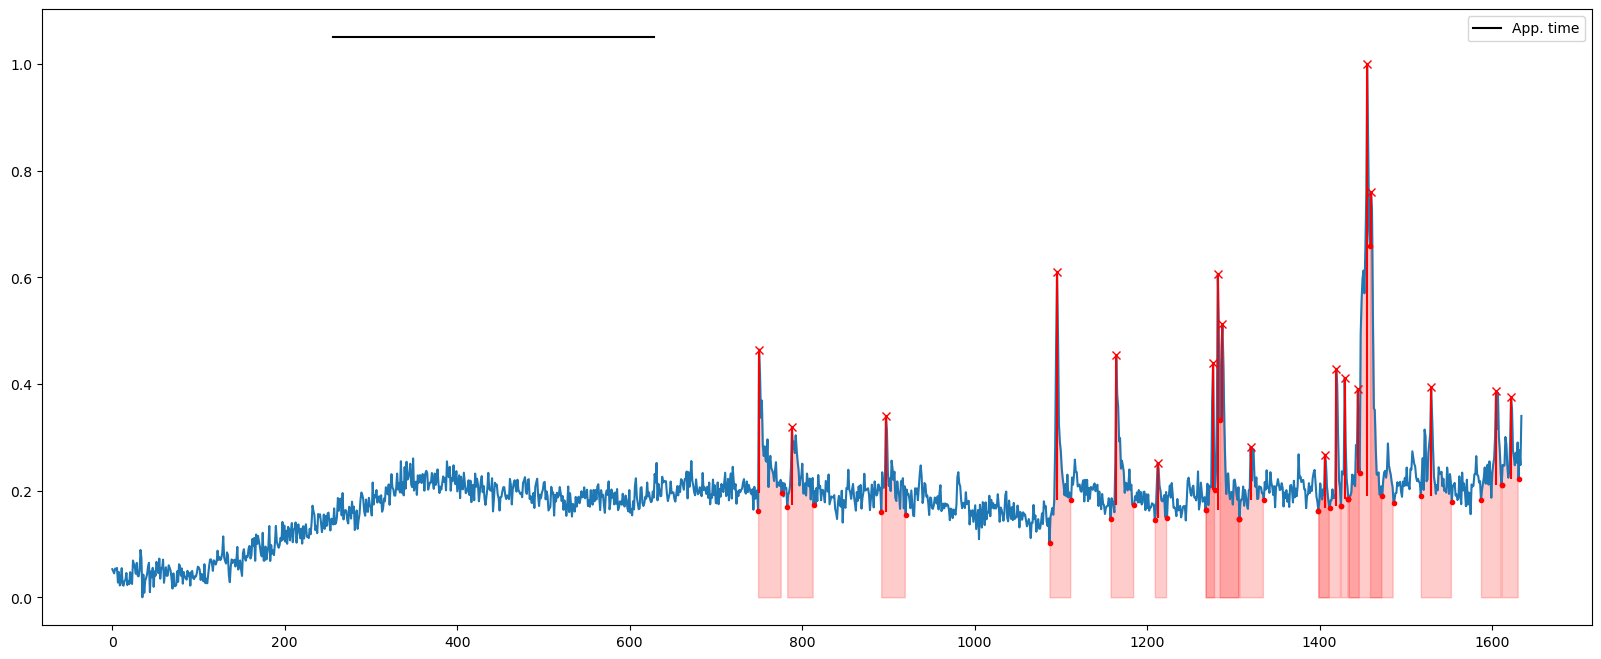

In [18]:
one_comp_profile = norm_profiles[0]

comp_profile = one_comp_profile[1]#[300:800]
time_line_demo = time_line#[300:800]

# detection
peaks, properties = signal.find_peaks(comp_profile,
                                      height=None,
                                      threshold=None,
                                      distance=min_distance_frames,
                                      wlen=50,
                                      prominence=0.1,
                                      rel_height=0.5,
                                      width=width_frames,
                                      plateau_size=plat_frames)
prom = properties['prominences']
print(properties)

# plotting
prom_h = comp_profile[peaks] - prom
width_w = np.sort(np.asarray([*properties['left_bases'], *properties['right_bases']], dtype=int))
width_pairs =  np.asarray(list(zip(properties['left_bases'], properties['right_bases'])), dtype=int)

app_y = [np.max(comp_profile)+np.max(comp_profile)*0.05] * len(app_line)

plt.figure(figsize=(20, 8))
plt.plot(time_line_demo, comp_profile)
plt.plot(time_line_demo[peaks], comp_profile[peaks], 'x', color='red')
plt.plot(time_line_demo[width_w], comp_profile[width_w], '.', color='red')
plt.plot(app_line, app_y, label='App. time', color='k')
plt.vlines(x=time_line_demo[peaks], ymin=prom_h, ymax=comp_profile[peaks], color='red')

for peak_width in width_pairs:
    plt.fill_between(
            x= time_line_demo[peak_width[0]:peak_width[1]], 
            y1= comp_profile[peak_width[0]:peak_width[1]], 
            color= "red",
            alpha= 0.2)

    
plt.legend()
plt.show()

# Dim. reduction and clasterization

## Preprocessing

#### Raw/norm data frames

In [ ]:
abs_df = pf_df.copy()
abs_df = abs_df.iloc[:,:12]

norm_df = pf_df.copy()
norm_df = norm_df.drop(list(norm_df.columns[9:12]), axis=1)

#### Features importance estimation

In [ ]:
# https://python-bloggers.com/2021/01/3-essential-ways-to-calculate-feature-importance-in-python/

abs_features_vals = abs_df.iloc[:,6:].values

abs_pca = PCA()
abs_features_pca = abs_pca.fit(X=abs_features_vals)

print(abs_features_pca)

plt.plot(abs_features_pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.show()



## PCA

#### PCA calc

In [ ]:
def PCA_calc(features_vals, factor_df, n=2):
    tic = time.perf_counter()

    if n == 2:
        ax_list = ['x', 'y']
    elif n == 3:
        ax_list = ['x', 'y', 'z']
    else:
        logging.fatal('Incorrect dimension number!')

    pca = PCA(n_components=n)
    principal_res = pca.fit_transform(features_vals)
    df_principal = pd.DataFrame(data = principal_res,
                                columns = ax_list)
    df_principal = pd.concat([factor_df, df_principal], axis = 1)

    toc = time.perf_counter()
    logging.info(f'PCA calc in {toc - tic:0.4f} seconds')
    return df_principal

n_components = 3
features_vals = abs_df.iloc[:,6:].values
factor_df = abs_df.iloc[:,:6]

pca_df = PCA_calc(features_vals=features_vals, factor_df=factor_df, n=n_components)

#### PCA plot

In [ ]:
group_factor = 'app_group'

if n_components == 2:
    fig = px.scatter(pca_df,
                     x='x', y='y',
                     color=group_factor,
                     symbol=group_factor)
    dot_size = 6
elif n_components == 3:
    fig = px.scatter_3d(pca_df,
                        x='x', y='y', z='z',
                        color=group_factor,
                        symbol=group_factor)
    dot_size = 2
else:
    logging.fatal('Incorrect n')

fig.update_traces(marker=dict(size=5))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),
                  legend= {'itemsizing': 'constant'},
                  scene=dict(xaxis=dict(showaxeslabels=False, showticklabels=False, showbackground=False, title=''),
                             yaxis=dict(showaxeslabels=False, showticklabels=False, showbackground=False, title=''), 
                             zaxis=dict(showaxeslabels=False, showticklabels=False, showbackground=False, title='')))
fig.show()

## LDA

#### LDA calc

In [ ]:
def LDA_calc(features_vals, factor_df, group_column=None):
    tic = time.perf_counter()

    group_vals = factor_df.loc[:,group_column].values

    lda = LDA()
    lda_fit = lda.fit_transform(X=features_vals, y=group_vals)
    df_lda = pd.DataFrame({'lda':lda_fit[:,0]})
    df_lda = pd.concat([factor_df, df_lda], axis = 1)

    toc = time.perf_counter()
    logging.info(f'PCA calc in {toc - tic:0.4f} seconds')
    return df_lda

features_vals = norm_df.iloc[:,6:].values
lda_df = LDA_calc(features_vals=features_vals, factor_df=norm_df.iloc[:,:6], group_column='app_group')

# plotting
fig = px.box(lda_df, x="app_group", y="lda", color='app_group', points='all')
fig.show()

## Clustergram

In [ ]:
cgram = CGram(range(1, 16), n_init=1000)

cgram.fit(norm_df.iloc[:,6:])

In [ ]:
ax = cgram.plot(figsize=(10, 8))
ax.yaxis.grid(False)